<a href="https://colab.research.google.com/github/munipallysanthoshkumar/My-Project/blob/main/Project_model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Data Preparation

### Import libraries

In [1]:
!pip -q install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 21.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
import hashlib
from PIL import Image
from collections import defaultdict
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from tensorflow.keras.preprocessing import image
from lime import lime_image
from skimage.segmentation import mark_boundaries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from google.colab import files
import os
from sklearn.utils.class_weight import compute_class_weight

In [3]:
np.random.seed(12049)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Loading / Setup

In [5]:
drive.mount('/content/drive')

project_path = "/content/drive/MyDrive/knee_oa_project"
zip_path = "/content/drive/MyDrive/KneeXrayData.zip"
extract_path = f"{project_path}/dataset"

# make folders if not there
os.makedirs(project_path, exist_ok=True)
os.makedirs(extract_path, exist_ok=True)

print("Project folder:", project_path)
print("Extract folder:", extract_path)

# unzip only if dataset folder looks empty
if not os.path.exists(zip_path):
    raise FileNotFoundError("KneeXrayData.zip not found in Drive. Please upload it first.")

if len(os.listdir(extract_path)) == 0:
    print("Unzipping dataset...")
    !unzip -q "{zip_path}" -d "{extract_path}"
    print("Done.")
else:
    print("Dataset already extracted. Skipping unzip.")

# paths for train/val/test (based on your dataset structure)
train_dir = f"{extract_path}/KneeXrayData/ClsKLData/kneeKL224/train"
val_dir   = f"{extract_path}/KneeXrayData/ClsKLData/kneeKL224/val"
test_dir  = f"{extract_path}/KneeXrayData/ClsKLData/kneeKL224/test"

print("\nTrain:", train_dir)
print("Val  :", val_dir)
print("Test :", test_dir)

# quick check
for p in [train_dir, val_dir, test_dir]:
    if not os.path.exists(p):
        print("Missing:", p)
    else:
        print("Found:", p)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Project folder: /content/drive/MyDrive/knee_oa_project
Extract folder: /content/drive/MyDrive/knee_oa_project/dataset
Dataset already extracted. Skipping unzip.

Train: /content/drive/MyDrive/knee_oa_project/dataset/KneeXrayData/ClsKLData/kneeKL224/train
Val  : /content/drive/MyDrive/knee_oa_project/dataset/KneeXrayData/ClsKLData/kneeKL224/val
Test : /content/drive/MyDrive/knee_oa_project/dataset/KneeXrayData/ClsKLData/kneeKL224/test
Found: /content/drive/MyDrive/knee_oa_project/dataset/KneeXrayData/ClsKLData/kneeKL224/train
Found: /content/drive/MyDrive/knee_oa_project/dataset/KneeXrayData/ClsKLData/kneeKL224/val
Found: /content/drive/MyDrive/knee_oa_project/dataset/KneeXrayData/ClsKLData/kneeKL224/test


# Data Exploration


Train data:
Grade 0 (Healthy): 2286 images (39.56%)
Grade 1 (Doubtful): 1046 images (18.1%)
Grade 2 (Minimal): 1516 images (26.24%)
Grade 3 (Moderate): 757 images (13.1%)
Grade 4 (Severe): 173 images (2.99%)

Validation data:
Grade 0 (Healthy): 328 images (39.71%)
Grade 1 (Doubtful): 153 images (18.52%)
Grade 2 (Minimal): 212 images (25.67%)
Grade 3 (Moderate): 106 images (12.83%)
Grade 4 (Severe): 27 images (3.27%)

Test data:
Grade 0 (Healthy): 639 images (38.59%)
Grade 1 (Doubtful): 296 images (17.87%)
Grade 2 (Minimal): 447 images (26.99%)
Grade 3 (Moderate): 223 images (13.47%)
Grade 4 (Severe): 51 images (3.08%)


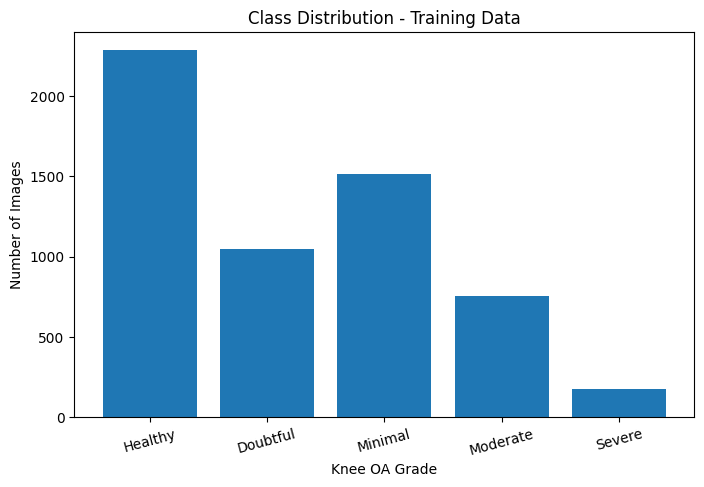

In [6]:
# class names (KL grades)
class_names = ['Healthy', 'Doubtful', 'Minimal', 'Moderate', 'Severe']

def get_class_counts(data_path, name):
    print(f"\n{name} data:")
    total = 0
    counts = {}

    for i in range(len(class_names)):
        class_path = os.path.join(data_path, str(i))
        num_images = len(os.listdir(class_path))
        counts[i] = num_images
        total += num_images

    for k, v in counts.items():
        pct = round((v / total) * 100, 2)
        print(f"Grade {k} ({class_names[k]}): {v} images ({pct}%)")

    return counts

# get counts
train_counts = get_class_counts(train_dir, "Train")
val_counts   = get_class_counts(val_dir, "Validation")
test_counts  = get_class_counts(test_dir, "Test")

plt.figure(figsize=(8,5))
plt.bar(class_names, train_counts.values())
plt.title("Class Distribution - Training Data")
plt.xlabel("Knee OA Grade")
plt.ylabel("Number of Images")
plt.xticks(rotation=15)
plt.show()

# Show sample images from each class (train)


Sample images - Grade 0 (Healthy)


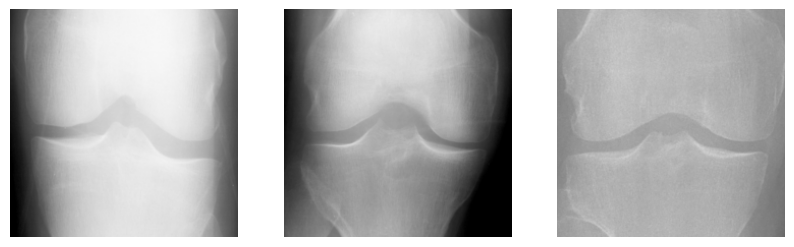


Sample images - Grade 1 (Doubtful)


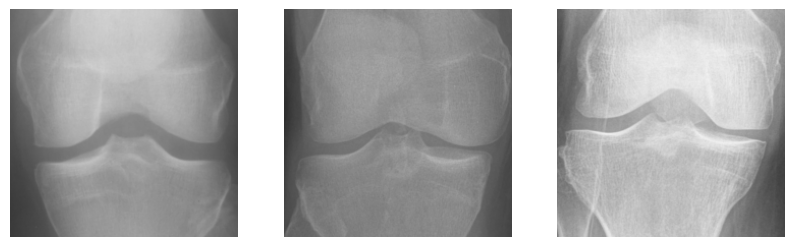


Sample images - Grade 2 (Minimal)


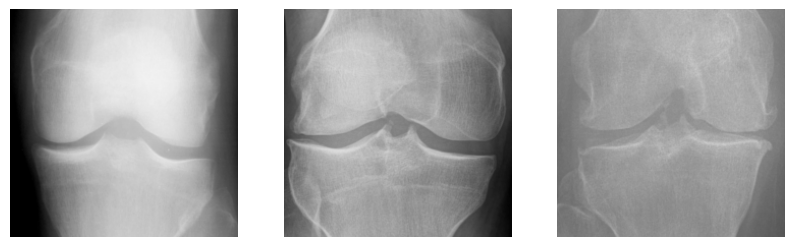


Sample images - Grade 3 (Moderate)


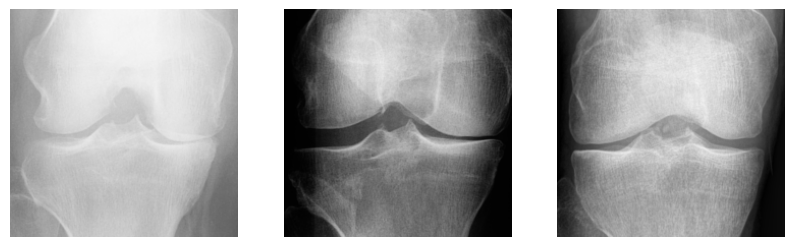


Sample images - Grade 4 (Severe)


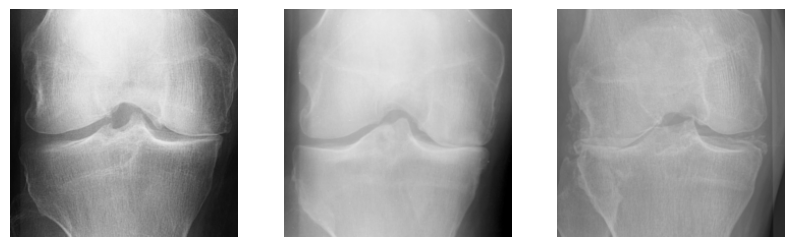

In [7]:
def show_sample_images(data_path, samples_per_class=3):
    for i in range(len(class_names)):
        class_path = os.path.join(data_path, str(i))
        images = os.listdir(class_path)

        print(f"\nSample images - Grade {i} ({class_names[i]})")
        plt.figure(figsize=(10,3))

        for j in range(min(samples_per_class, len(images))):
            img_path = os.path.join(class_path, images[j])
            img = tf.keras.preprocessing.image.load_img(img_path)

            plt.subplot(1, samples_per_class, j + 1)
            plt.imshow(img, cmap="gray")
            plt.axis("off")

        plt.show()

# show samples from training set
show_sample_images(train_dir)

# Data Quality & Integrity Checks

In [8]:
def find_duplicates(dataset_dir, name):
    print(f"\nChecking exact duplicates in {name}...")
    hashes = defaultdict(list)

    for class_folder in os.listdir(dataset_dir):
        class_path = os.path.join(dataset_dir, class_folder)
        if not os.path.isdir(class_path):
            continue

        for fname in os.listdir(class_path):
            fpath = os.path.join(class_path, fname)
            if not os.path.isfile(fpath):
                continue

            with open(fpath, "rb") as f:
                h = hashlib.md5(f.read()).hexdigest()
            hashes[h].append(fpath)

    duplicates = {h: files for h, files in hashes.items() if len(files) > 1}

    if len(duplicates) == 0:
        print("No exact duplicates found.")
    else:
        print("Duplicate groups found:", len(duplicates))
        # show first few groups
        shown = 0
        for h, files in duplicates.items():
            print("\nHash:", h)
            for f in files:
                print(" -", f)
            shown += 1
            if shown == 3:
                break

    return duplicates


train_dups = find_duplicates(train_dir, "Train")
val_dups   = find_duplicates(val_dir, "Validation")
test_dups  = find_duplicates(test_dir, "Test")


Checking exact duplicates in Train...
No exact duplicates found.

Checking exact duplicates in Validation...
No exact duplicates found.

Checking exact duplicates in Test...
No exact duplicates found.


In [9]:
def find_cross_duplicates(dir1, dir2, name1, name2):
    print(f"\nChecking cross-duplicates between {name1} and {name2}...")

    hashes1 = {}
    for class_folder in os.listdir(dir1):
        class_path = os.path.join(dir1, class_folder)
        if not os.path.isdir(class_path):
            continue

        for fname in os.listdir(class_path):
            fpath = os.path.join(class_path, fname)
            if not os.path.isfile(fpath):
                continue

            with open(fpath, "rb") as f:
                h = hashlib.md5(f.read()).hexdigest()
            hashes1[h] = fpath

    cross = []
    for class_folder in os.listdir(dir2):
        class_path = os.path.join(dir2, class_folder)
        if not os.path.isdir(class_path):
            continue

        for fname in os.listdir(class_path):
            fpath = os.path.join(class_path, fname)
            if not os.path.isfile(fpath):
                continue

            with open(fpath, "rb") as f:
                h = hashlib.md5(f.read()).hexdigest()

            if h in hashes1:
                cross.append((hashes1[h], fpath))

    if len(cross) == 0:
        print("No cross-duplicates found.")
    else:
        print("Cross-duplicates found:", len(cross))
        for a, b in cross[:10]:
            print(" -", a)
            print("   ", b)

    return cross


train_val_cross = find_cross_duplicates(train_dir, val_dir, "Train", "Validation")
train_test_cross = find_cross_duplicates(train_dir, test_dir, "Train", "Test")
val_test_cross = find_cross_duplicates(val_dir, test_dir, "Validation", "Test")


Checking cross-duplicates between Train and Validation...
No cross-duplicates found.

Checking cross-duplicates between Train and Test...
No cross-duplicates found.

Checking cross-duplicates between Validation and Test...
No cross-duplicates found.


# Binary Class Mapping

In [10]:
binary_map = {0: 0, 1: 0, 2: 1, 3: 1, 4: 1}
binary_class_names = ["Non-OA", "OA"]

print("Binary mapping:", binary_map)
print("Binary classes:", binary_class_names)


Binary mapping: {0: 0, 1: 0, 2: 1, 3: 1, 4: 1}
Binary classes: ['Non-OA', 'OA']


In [11]:
def get_binary_counts(data_dir, name):
    total = 0
    bin_counts = {0: 0, 1: 0}

    for grade in range(5):
        class_path = os.path.join(data_dir, str(grade))
        if not os.path.exists(class_path):
            raise FileNotFoundError(f"Missing folder: {class_path}")

        n = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
        bin_label = binary_map[grade]
        bin_counts[bin_label] += n
        total += n

    print(f"\n{name} Binary Distribution:")
    for k in [0, 1]:
        pct = round((bin_counts[k] / total) * 100, 2) if total > 0 else 0
        print(f"{binary_class_names[k]} ({k}): {bin_counts[k]} images ({pct}%)")

    print("Total:", total)
    return bin_counts

train_bin_counts = get_binary_counts(train_dir, "Train")
val_bin_counts   = get_binary_counts(val_dir, "Validation")
test_bin_counts  = get_binary_counts(test_dir, "Test")


Train Binary Distribution:
Non-OA (0): 3332 images (57.67%)
OA (1): 2446 images (42.33%)
Total: 5778

Validation Binary Distribution:
Non-OA (0): 481 images (58.23%)
OA (1): 345 images (41.77%)
Total: 826

Test Binary Distribution:
Non-OA (0): 935 images (56.46%)
OA (1): 721 images (43.54%)
Total: 1656


In [13]:
labels = sorted(set(binary_map.values()))
print("Unique binary labels from mapping:", labels)

assert labels == [0, 1], "Binary mapping is incorrect. Expected labels [0,1]."
print("Mapping sanity check passed.")

Unique binary labels from mapping: [0, 1]
Mapping sanity check passed.


In [12]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_test_datagen = ImageDataGenerator(
    rescale=1./255
)

print("IMG_SIZE:", IMG_SIZE, "| BATCH_SIZE:", BATCH_SIZE)

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_test_datagen = ImageDataGenerator(
    rescale=1./255
)

print("IMG_SIZE:", IMG_SIZE, "| BATCH_SIZE:", BATCH_SIZE)

IMG_SIZE: (224, 224) | BATCH_SIZE: 32
IMG_SIZE: (224, 224) | BATCH_SIZE: 32


In [14]:
train_gen_5 = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=True,
    seed=42
)

val_gen_5 = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=False
)

test_gen_5 = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=False
)

Found 5778 images belonging to 5 classes.
Found 826 images belonging to 5 classes.
Found 1656 images belonging to 5 classes.


In [15]:
def gen_to_binary_dataset(gen5):
    while True:
        x, y = next(gen5)
        y = y.astype(int)
        y_bin = np.vectorize(binary_map.get)(y)  # map 0-4 -> 0/1
        yield x, y_bin.astype(np.float32)

output_signature = (
    tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
    tf.TensorSpec(shape=(None,), dtype=tf.float32)
)

train_ds = tf.data.Dataset.from_generator(lambda: gen_to_binary_dataset(train_gen_5),
                                          output_signature=output_signature).prefetch(tf.data.AUTOTUNE)

val_ds   = tf.data.Dataset.from_generator(lambda: gen_to_binary_dataset(val_gen_5),
                                          output_signature=output_signature).prefetch(tf.data.AUTOTUNE)

test_ds  = tf.data.Dataset.from_generator(lambda: gen_to_binary_dataset(test_gen_5),
                                          output_signature=output_signature).prefetch(tf.data.AUTOTUNE)

print("Binary datasets created: train_ds, val_ds, test_ds")


Binary datasets created: train_ds, val_ds, test_ds


In [16]:
xb, yb = next(iter(train_ds))
print("X batch shape:", xb.shape)
print("y batch shape:", yb.shape)
print("Unique labels in this batch:", np.unique(yb))

assert xb.shape[1:] == (224, 224, 3), "Image shape mismatch"
assert set(np.unique(yb)).issubset({0.0, 1.0}), "Binary labels should be 0/1 only"
print("Batch sanity check passed.")

X batch shape: (32, 224, 224, 3)
y batch shape: (32,)
Unique labels in this batch: [0. 1.]
Batch sanity check passed.


In [ ]:
preprocess_fn = tf.keras.applications.efficientnet.preprocess_input

base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)
base_model.trainable = False

inputs = layers.Input(shape=(224, 224, 3))

x = layers.Lambda(lambda t: t * 255.0)(inputs)
x = layers.Lambda(preprocess_fn)(x)

x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = models.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_2 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_3 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
original_train_labels = train_gen_5.classes
binary_train_labels = np.vectorize(binary_map.get)(original_train_labels)

class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(binary_train_labels),
    y=binary_train_labels
)

class_weight_dict = {int(i): weight for i, weight in enumerate(class_weights_array)}

print("Calculated Class Weights:", class_weight_dict)

model_out = f"{project_path}/models"
os.makedirs(model_out, exist_ok=True)

checkpoint_path = f"{model_out}/binary_efficientnetb0_best.weights.h5"

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path, monitor="val_auc", mode="max",
        save_best_only=True, save_weights_only=True, verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_auc", mode="max", patience=5,
        restore_best_weights=True, verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_auc", mode="max", factor=0.5, patience=2,
        min_lr=1e-6, verbose=1
    )
]

EPOCHS = 100

tf.config.run_functions_eagerly(True)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    steps_per_epoch=len(train_gen_5),
    validation_steps=len(val_gen_5),
    callbacks=callbacks,
    class_weight=class_weight_dict
)

Calculated Class Weights: {0: np.float64(0.867046818727491), 1: np.float64(1.1811120196238758)}
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6717 - auc: 0.7290 - loss: 0.6136
Epoch 1: val_auc improved from -inf to 0.82814, saving model to /content/drive/MyDrive/knee_oa_project/models/binary_efficientnetb0_best.weights.h5
181/181 ━━━━━━━━━━━━━━━━━━━━ 348s 2s/step - accuracy: 0.6720 - auc: 0.7294 - loss: 0.6132 - val_accuracy: 0.7676 - val_auc: 0.8281 - val_loss: 0.4960 - learning_rate: 1.0000e-04
Epoch 2/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7832 - auc: 0.8727 - loss: 0.4410
Epoch 2: val_auc improved from 0.82814 to 0.88757, saving model to /content/drive/MyDrive/knee_oa_project/models/binary_efficientnetb0_best.weights.h5
181/181 ━━━━━━━━━━━━━━━━━━━━ 345s 2s/step - accuracy: 0.7833 - auc: 0.8727 - loss: 0.4410 - val_accuracy: 0.7300 - val_auc: 0.8876 - val_loss: 0.5874 - learning_rate: 1.0000e-04
Epoch 3/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8164 - auc: 0.8999 - loss: 0.3978
Epoch 3: val_auc improved from 0.88757 to 0.89580, saving

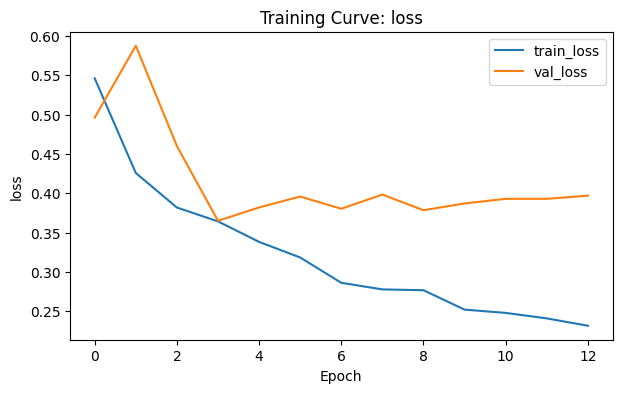

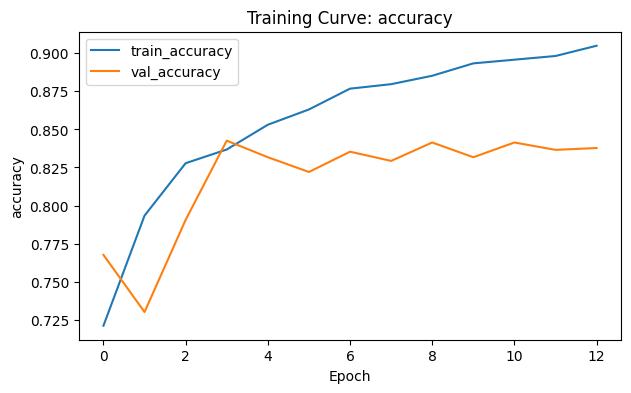

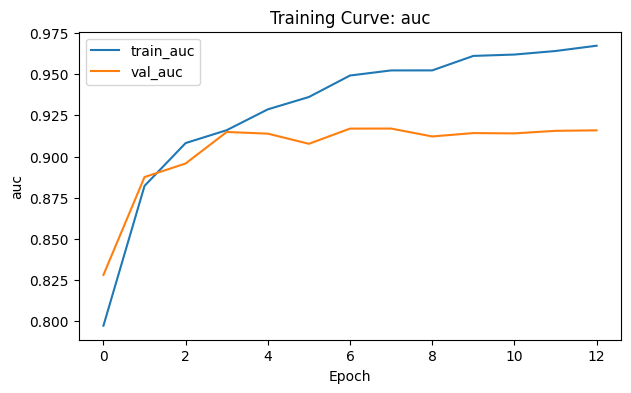

In [ ]:
def plot_history(history):
    hist = history.history
    for key in ["loss", "accuracy", "auc"]:
        plt.figure(figsize=(7,4))
        plt.plot(hist[key], label=f"train_{key}")
        plt.plot(hist[f"val_{key}"], label=f"val_{key}")
        plt.title(f"Training Curve: {key}")
        plt.xlabel("Epoch")
        plt.ylabel(key)
        plt.legend()
        plt.show()

plot_history(history)

In [ ]:
model.load_weights(checkpoint_path)
print("Loaded best weights:", checkpoint_path)

Loaded best weights: /content/drive/MyDrive/knee_oa_project/models/binary_efficientnetb0_best.weights.h5


In [ ]:
val_results = model.evaluate(
    val_ds,
    steps=len(val_gen_5),
    verbose=1
)

val_loss, val_accuracy, val_auc = val_results

print(f"Validation Loss     : {val_loss:.4f}")
print(f"Validation Accuracy : {val_accuracy:.4f}")
print(f"Validation ROC-AUC  : {val_auc:.4f}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 338ms/step - accuracy: 0.8474 - auc: 0.5316 - loss: 0.3781
Validation Loss     : 0.3984
Validation Accuracy : 0.8293
Validation ROC-AUC  : 0.9170


In [ ]:
test_results = model.evaluate(
    test_ds,
    steps=len(test_gen_5),
    verbose=1
)

test_loss, test_accuracy, test_auc = test_results

print(f"Test Loss     : {test_loss:.4f}")
print(f"Test Accuracy : {test_accuracy:.4f}")
print(f"Test ROC-AUC  : {test_auc:.4f}")

52/52 ━━━━━━━━━━━━━━━━━━━━ 18s 341ms/step - accuracy: 0.8832 - auc: 0.9388 - loss: 0.2910
Test Loss     : 0.3831
Test Accuracy : 0.8388
Test ROC-AUC  : 0.9184


In [ ]:
y_true = []
y_prob = []

steps = len(test_gen_5)

for _ in range(steps):
    xb, yb = next(iter(test_ds))
    probs = model.predict(xb, verbose=0).ravel()
    y_true.extend(yb.numpy().tolist())
    y_prob.extend(probs.tolist())

y_true = np.array(y_true)[:test_gen_5.samples]
y_prob = np.array(y_prob)[:test_gen_5.samples]

y_pred = (y_prob >= 0.5).astype(int)

print("Test samples:", len(y_true))
print("Test ROC-AUC:", round(roc_auc_score(y_true, y_prob), 4))
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=binary_class_names))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

/usr/local/lib/python3.12/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Test samples: 1656
Test ROC-AUC: 0.9105

Classification Report:
               precision    recall  f1-score   support

      Non-OA       0.85      0.87      0.86       960
          OA       0.81      0.79      0.80       696

    accuracy                           0.84      1656
   macro avg       0.83      0.83      0.83      1656
weighted avg       0.84      0.84      0.84      1656

Confusion Matrix:
 [[834 126]
 [144 552]]


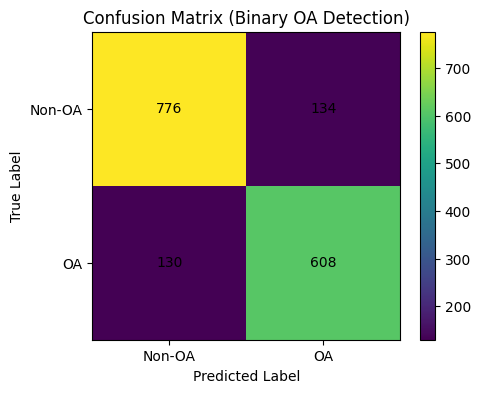

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,4))
plt.imshow(cm)
plt.title("Confusion Matrix (Binary OA Detection)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks([0,1], binary_class_names)
plt.yticks([0,1], binary_class_names)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.colorbar()
plt.show()

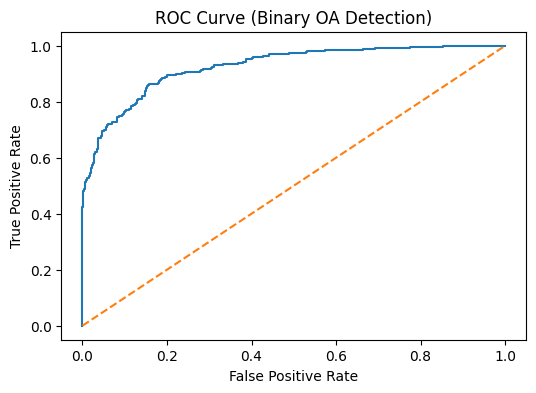

In [ ]:
fpr, tpr, thresholds = roc_curve(y_true, y_prob)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle="--")
plt.title("ROC Curve (Binary OA Detection)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [ ]:
tf.config.run_functions_eagerly(False)

model.load_weights(checkpoint_path)
print("Loaded best weights:", checkpoint_path)


Loaded best weights: /content/drive/MyDrive/knee_oa_project/models/binary_efficientnetb0_best.weights.h5


In [ ]:
val_loss, val_acc, val_auc = model.evaluate(val_ds, steps=len(val_gen_5), verbose=1)
print("\n=== Validation Results ===")
print(f"Val Loss     : {val_loss:.4f}")
print(f"Val Accuracy : {val_acc:.4f}")
print(f"Val ROC-AUC  : {val_auc:.4f}")

test_loss, test_acc, test_auc = model.evaluate(test_ds, steps=len(test_gen_5), verbose=1)
print("\n=== Test Results ===")
print(f"Test Loss     : {test_loss:.4f}")
print(f"Test Accuracy : {test_acc:.4f}")
print(f"Test ROC-AUC  : {test_auc:.4f}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 15s 299ms/step - accuracy: 0.8430 - auc: 0.5643 - loss: 0.3787

=== Validation Results ===
Val Loss     : 0.3984
Val Accuracy : 0.8293
Val ROC-AUC  : 0.9170
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 207ms/step - accuracy: 0.8746 - auc: 0.4050 - loss: 0.3117

=== Test Results ===
Test Loss     : 0.3831
Test Accuracy : 0.8388
Test ROC-AUC  : 0.9184


In [ ]:
y_true = []
y_prob = []

for x_batch, y_batch in test_ds.take(len(test_gen_5)):
    probs = model.predict(x_batch, verbose=0).reshape(-1)
    y_prob.extend(probs.tolist())
    y_true.extend(y_batch.numpy().astype(int).tolist())

y_true = np.array(y_true)
y_prob = np.array(y_prob)

y_pred = (y_prob >= 0.5).astype(int)

auc_full = roc_auc_score(y_true, y_prob)

print("\n=== Test Detailed Metrics ===")
print(f"Test ROC-AUC (sklearn): {auc_full:.4f}\n")

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=binary_class_names))

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)


=== Test Detailed Metrics ===
Test ROC-AUC (sklearn): 0.9187

Classification Report:
              precision    recall  f1-score   support

      Non-OA       0.85      0.86      0.86       935
          OA       0.82      0.81      0.81       721

    accuracy                           0.84      1656
   macro avg       0.84      0.84      0.84      1656
weighted avg       0.84      0.84      0.84      1656

Confusion Matrix:
 [[805 130]
 [137 584]]


Using last conv layer for Grad-CAM: top_conv


Saving 9003175L.png to 9003175L (19).png
Uploaded: 9003175L (19).png
Prediction      : Non-OA
Confidence      : 89.37% (Non-OA)
P(OA)           : 0.1063
P(Non-OA)       : 0.8937
Threshold       : 0.50


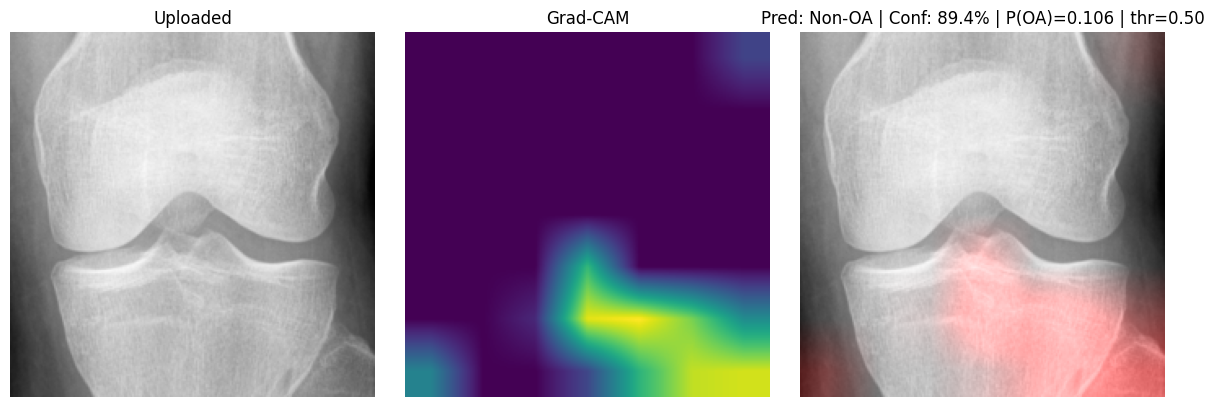

In [ ]:
tf.config.run_functions_eagerly(False)


THRESHOLD = 0.50
ALPHA = 0.50
SAVE_TO_DRIVE = False
SAVE_DIR = f"{project_path}/results/gradcam"


def plot_gradcam_overlay(img_pil, heatmap, title="", alpha=0.5):
    img_np = np.array(img_pil).astype("float32") / 255.0
    heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], (224, 224)).numpy().squeeze()

    overlay = img_np.copy()
    overlay[..., 0] = np.clip(overlay[..., 0] + alpha * heatmap_resized, 0, 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1); plt.imshow(img_np); plt.axis("off"); plt.title("Uploaded")
    plt.subplot(1, 3, 2); plt.imshow(heatmap_resized); plt.axis("off"); plt.title("Grad-CAM")
    plt.subplot(1, 3, 3); plt.imshow(overlay); plt.axis("off"); plt.title(title)
    plt.tight_layout()
    return plt.gcf()


lambda_layers = [l for l in model.layers if isinstance(l, tf.keras.layers.Lambda)]
assert len(lambda_layers) >= 2, "Missing preprocessing Lambda layers (scale + preprocess)."
preprocess_model = tf.keras.Model(inputs=model.inputs, outputs=lambda_layers[1].output)

backbone = model.get_layer("efficientnetb0")

last_conv_name = None
for lyr in backbone.layers[::-1]:
    if isinstance(lyr, tf.keras.layers.Conv2D):
        last_conv_name = lyr.name
        break
print("Using last conv layer for Grad-CAM:", last_conv_name)

backbone_multi = tf.keras.Model(
    inputs=backbone.input,
    outputs=[backbone.get_layer(last_conv_name).output, backbone.output]
)

gap_layer = next(l for l in model.layers if isinstance(l, tf.keras.layers.GlobalAveragePooling2D))
dense_layer = next(l for l in model.layers if isinstance(l, tf.keras.layers.Dense) and l.units == 1)
drop_layer = None
for l in model.layers:
    if isinstance(l, tf.keras.layers.Dropout):
        drop_layer = l
        break


uploaded = files.upload()
img_path = list(uploaded.keys())[0]
print("Uploaded:", img_path)

img_pil = image.load_img(img_path, target_size=(224, 224))
img_arr_01 = image.img_to_array(img_pil) / 255.0
img_batch = np.expand_dims(img_arr_01, axis=0).astype(np.float32)

prob_oa = float(model.predict(img_batch, verbose=0)[0][0])
prob_non = 1.0 - prob_oa

pred_label = "OA" if prob_oa >= THRESHOLD else "Non-OA"
conf = prob_oa if pred_label == "OA" else prob_non

print(f"Prediction      : {pred_label}")
print(f"Confidence      : {conf*100:.2f}% ({pred_label})")
print(f"P(OA)           : {prob_oa:.4f}")
print(f"P(Non-OA)       : {prob_non:.4f}")
print(f"Threshold       : {THRESHOLD:.2f}")

img_tf = tf.convert_to_tensor(img_batch, dtype=tf.float32)
x_backbone = preprocess_model(img_tf, training=False)

with tf.GradientTape() as tape:
    conv_maps, backbone_out = backbone_multi(x_backbone, training=False)
    x = gap_layer(backbone_out)
    if drop_layer is not None:
        x = drop_layer(x, training=False)
    preds = dense_layer(x)
    score = preds[:, 0]
    tape.watch(conv_maps)

grads = tape.gradient(score, conv_maps)
if grads is None:
    raise RuntimeError(
        "Gradients are None. If this happens, Runtime > Restart runtime, "
        "run model build + load_weights, then run this cell."
    )

pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
conv_maps = conv_maps[0]
heatmap = tf.reduce_sum(conv_maps * pooled_grads, axis=-1)
heatmap = tf.maximum(heatmap, 0)
heatmap = heatmap / (tf.reduce_max(heatmap) + 1e-8)
heatmap = heatmap.numpy()

title = f"Pred: {pred_label} | Conf: {conf*100:.1f}% | P(OA)={prob_oa:.3f} | thr={THRESHOLD:.2f}"
fig = plot_gradcam_overlay(img_pil, heatmap, title=title, alpha=ALPHA)
plt.show()

if SAVE_TO_DRIVE:
    os.makedirs(SAVE_DIR, exist_ok=True)
    base = os.path.splitext(os.path.basename(img_path))[0]
    out_path = f"{SAVE_DIR}/{base}_pred-{pred_label}_conf-{conf*100:.1f}_gradcam.png"
    fig.savefig(out_path, dpi=200, bbox_inches="tight")
    print("Saved:", out_path)


Saving 9003175L.png to 9003175L (20).png
Uploaded: 9003175L (20).png
Prediction      : Non-OA
Confidence      : 89.37% (Non-OA)
P(OA)           : 0.1063
P(Non-OA)       : 0.8937
Threshold       : 0.50


  0%|          | 0/1000 [00:00<?, ?it/s]

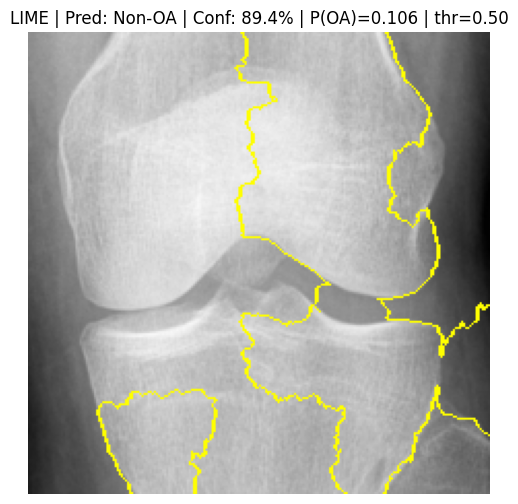

In [ ]:
THRESHOLD = 0.50
NUM_SAMPLES = 1000
NUM_FEATURES = 8
HIDE_REST = False
POSITIVE_ONLY = True

uploaded = files.upload()
img_path = list(uploaded.keys())[0]
print("Uploaded:", img_path)

img_pil = image.load_img(img_path, target_size=(224, 224))
img_arr_01 = image.img_to_array(img_pil) / 255.0
img_batch = np.expand_dims(img_arr_01, axis=0).astype(np.float32)


prob_oa = float(model.predict(img_batch, verbose=0)[0][0])
prob_non = 1.0 - prob_oa

pred_label = "OA" if prob_oa >= THRESHOLD else "Non-OA"
conf = prob_oa if pred_label == "OA" else prob_non

print(f"Prediction      : {pred_label}")
print(f"Confidence      : {conf*100:.2f}% ({pred_label})")
print(f"P(OA)           : {prob_oa:.4f}")
print(f"P(Non-OA)       : {prob_non:.4f}")
print(f"Threshold       : {THRESHOLD:.2f}")

img_uint8 = (img_arr_01 * 255).astype(np.uint8)


def lime_predict_fn(images_uint8):
    images_01 = images_uint8.astype(np.float32) / 255.0
    p_oa = model.predict(images_01, verbose=0).reshape(-1)
    p_non = 1.0 - p_oa
    return np.stack([p_non, p_oa], axis=1)


explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(
    img_uint8,
    classifier_fn=lime_predict_fn,
    top_labels=2,
    num_samples=NUM_SAMPLES
)


label_to_explain = 1 if pred_label == "OA" else 0

temp, mask = explanation.get_image_and_mask(
    label=label_to_explain,
    positive_only=POSITIVE_ONLY,
    num_features=NUM_FEATURES,
    hide_rest=HIDE_REST
)


title = f"LIME | Pred: {pred_label} | Conf: {conf*100:.1f}% | P(OA)={prob_oa:.3f} | thr={THRESHOLD:.2f}"

plt.figure(figsize=(6,6))
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.axis("off")
plt.title(title)
plt.show()


# ResNet50

In [18]:
preprocess_fn = tf.keras.applications.resnet.preprocess_input

base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)
base_model.trainable = False

inputs = layers.Input(shape=(224, 224, 3))

x = layers.Lambda(lambda t: t * 255.0)(inputs)   # dataset gives [0,1]
x = layers.Lambda(preprocess_fn)(x)

x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_resnet50 = models.Model(inputs, outputs, name="binary_resnet50")

model_resnet50.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

model_resnet50.summary()

Model: "binary_resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_2 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_3 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [19]:
model_out = f"{project_path}/models_compare"
os.makedirs(model_out, exist_ok=True)
checkpoint_path = f"{model_out}/binary_resnet50_best.weights.h5"

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path, monitor="val_auc", mode="max",
        save_best_only=True, save_weights_only=True, verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_auc", mode="max", patience=5,
        restore_best_weights=True, verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_auc", mode="max", factor=0.5, patience=2,
        min_lr=1e-6, verbose=1
    )
]

history_resnet50 = model_resnet50.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    steps_per_epoch=len(train_gen_5),
    validation_steps=len(val_gen_5),
    callbacks=callbacks
)

Epoch 1/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.5364 - auc: 0.5229 - loss: 0.7827
Epoch 1: val_auc improved from -inf to 0.60122, saving model to /content/drive/MyDrive/knee_oa_project/models_compare/binary_resnet50_best.weights.h5
181/181 ━━━━━━━━━━━━━━━━━━━━ 94s 464ms/step - accuracy: 0.5365 - auc: 0.5230 - loss: 0.7826 - val_accuracy: 0.6102 - val_auc: 0.6012 - val_loss: 0.6705 - learning_rate: 1.0000e-04
Epoch 2/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.5967 - auc: 0.6055 - loss: 0.7003
Epoch 2: val_auc improved from 0.60122 to 0.70721, saving model to /content/drive/MyDrive/knee_oa_project/models_compare/binary_resnet50_best.weights.h5
181/181 ━━━━━━━━━━━━━━━━━━━━ 73s 406ms/step - accuracy: 0.5968 - auc: 0.6057 - loss: 0.7002 - val_accuracy: 0.6731 - val_auc: 0.7072 - val_loss: 0.6152 - learning_rate: 1.0000e-04
Epoch 3/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.6404 - auc: 0.6671 - loss: 0.6524
Epoch 3: val_auc improved fr

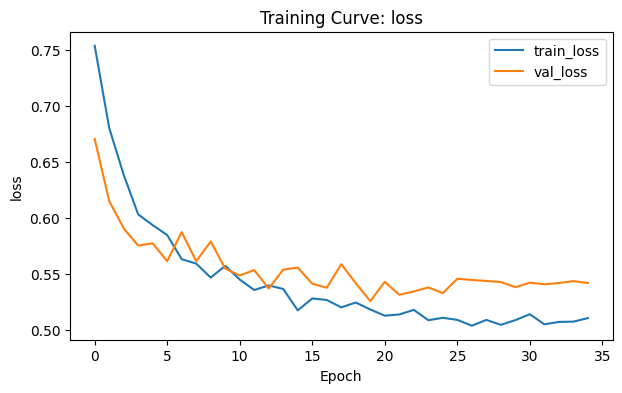

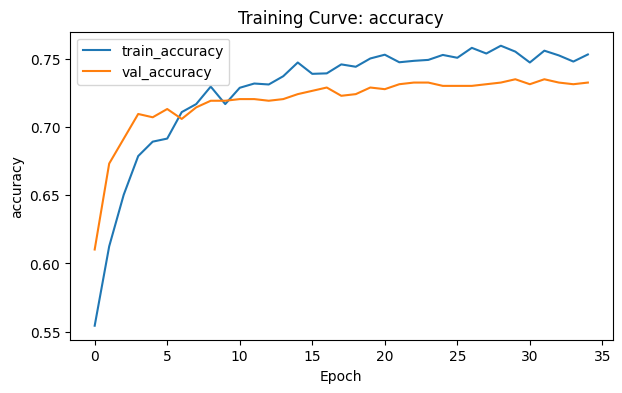

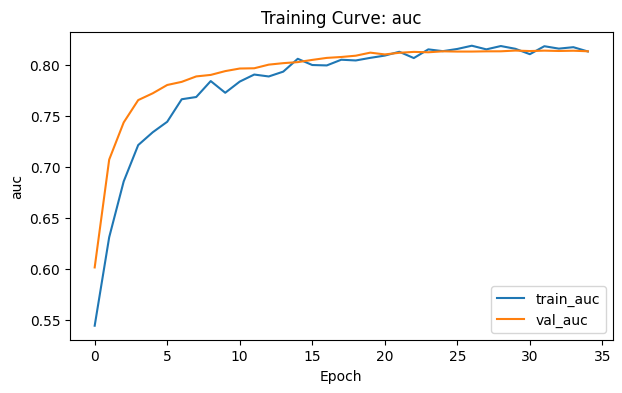

In [24]:
def plot_history(history):
    hist = history.history
    for key in ["loss", "accuracy", "auc"]:
        plt.figure(figsize=(7,4))
        plt.plot(hist[key], label=f"train_{key}")
        plt.plot(hist[f"val_{key}"], label=f"val_{key}")
        plt.title(f"Training Curve: {key}")
        plt.xlabel("Epoch")
        plt.ylabel(key)
        plt.legend()
        plt.show()

plot_history(history_resnet50)

In [26]:
model_resnet50.load_weights(checkpoint_path)
print("Loaded best weights:", checkpoint_path)

Loaded best weights: /content/drive/MyDrive/knee_oa_project/models_compare/binary_resnet50_best.weights.h5


In [28]:
val_results = model_resnet50.evaluate(
    val_ds,
    steps=len(val_gen_5),
    verbose=1
)

val_loss, val_accuracy, val_auc = val_results

print(f"Validation Loss     : {val_loss:.4f}")
print(f"Validation Accuracy : {val_accuracy:.4f}")
print(f"Validation ROC-AUC  : {val_auc:.4f}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.6750 - auc: 0.6319 - loss: 0.6353
Validation Loss     : 0.5384
Validation Accuracy : 0.7349
Validation ROC-AUC  : 0.8143


In [29]:
test_results = model_resnet50.evaluate(
    test_ds,
    steps=len(test_gen_5),
    verbose=1
)

test_loss, test_accuracy, test_auc = test_results

print(f"Test Loss     : {test_loss:.4f}")
print(f"Test Accuracy : {test_accuracy:.4f}")
print(f"Test ROC-AUC  : {test_auc:.4f}")

52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - accuracy: 0.8199 - auc: 0.5064 - loss: 0.4366
Test Loss     : 0.5667
Test Accuracy : 0.7319
Test ROC-AUC  : 0.8107


In [31]:
y_true = []
y_prob = []

steps = len(test_gen_5)

for _ in range(steps):
    xb, yb = next(iter(test_ds))
    probs = model_resnet50.predict(xb, verbose=0).ravel()
    y_true.extend(yb.numpy().tolist())
    y_prob.extend(probs.tolist())

y_true = np.array(y_true)[:test_gen_5.samples]
y_prob = np.array(y_prob)[:test_gen_5.samples]

y_pred = (y_prob >= 0.5).astype(int)

print("Test samples:", len(y_true))
print("Test ROC-AUC:", round(roc_auc_score(y_true, y_prob), 4))
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=binary_class_names))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

Test samples: 1648
Test ROC-AUC: 0.8238

Classification Report:
               precision    recall  f1-score   support

      Non-OA       0.68      0.96      0.80       910
          OA       0.90      0.45      0.60       738

    accuracy                           0.73      1648
   macro avg       0.79      0.71      0.70      1648
weighted avg       0.78      0.73      0.71      1648

Confusion Matrix:
 [[874  36]
 [406 332]]


Using last conv layer for Grad-CAM: conv5_block3_3_conv


Saving 9015718R.png to 9015718R.png
Uploaded: 9015718R.png
Prediction      : Non-OA
Confidence      : 93.91 % (Non-OA)
P(OA)           : 0.0609
P(Non-OA)       : 0.9391
Threshold       : 0.50


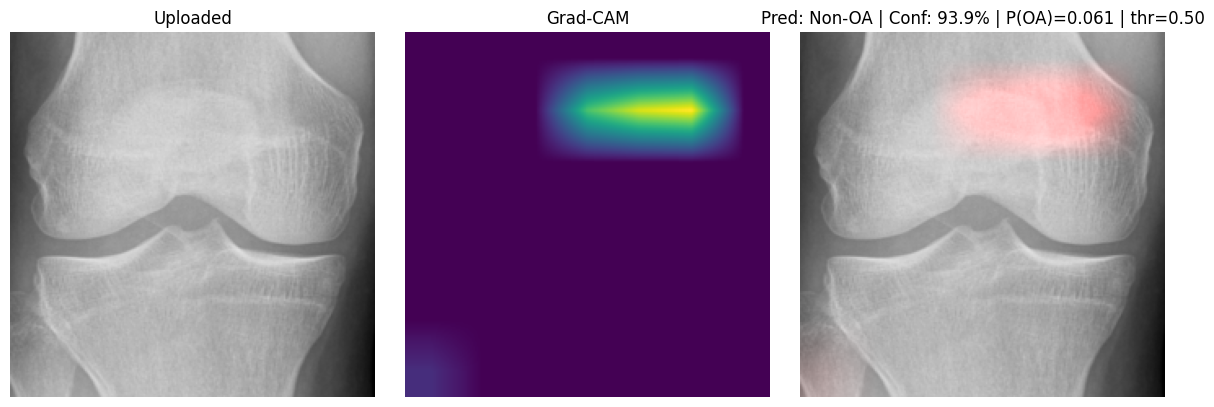

In [34]:
tf.config.run_functions_eagerly(False)


THRESHOLD = 0.50
ALPHA = 0.50
SAVE_TO_DRIVE = False
SAVE_DIR = f"{project_path}/results/gradcam"


def plot_gradcam_overlay(img_pil, heatmap, title="", alpha=0.5):
    img_np = np.array(img_pil).astype("float32") / 255.0
    heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], (224, 224)).numpy().squeeze()

    overlay = img_np.copy()
    overlay[..., 0] = np.clip(overlay[..., 0] + alpha * heatmap_resized, 0, 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1); plt.imshow(img_np); plt.axis("off"); plt.title("Uploaded")
    plt.subplot(1, 3, 2); plt.imshow(heatmap_resized); plt.axis("off"); plt.title("Grad-CAM")
    plt.subplot(1, 3, 3); plt.imshow(overlay); plt.axis("off"); plt.title(title)
    plt.tight_layout()
    return plt.gcf()


lambda_layers = [l for l in model_resnet50.layers if isinstance(l, tf.keras.layers.Lambda)]
assert len(lambda_layers) >= 2, "Missing preprocessing Lambda layers (scale + preprocess)."
preprocess_model = tf.keras.Model(inputs=model_resnet50.inputs, outputs=lambda_layers[1].output)

backbone = model_resnet50.get_layer("resnet50")

last_conv_name = None
for lyr in backbone.layers[::-1]:
    if isinstance(lyr, tf.keras.layers.Conv2D):
        last_conv_name = lyr.name
        break
print("Using last conv layer for Grad-CAM:", last_conv_name)

backbone_multi = tf.keras.Model(
    inputs=backbone.input,
    outputs=[backbone.get_layer(last_conv_name).output, backbone.output]
)

gap_layer = next(l for l in model_resnet50.layers if isinstance(l, tf.keras.layers.GlobalAveragePooling2D))
dense_layer = next(l for l in model_resnet50.layers if isinstance(l, tf.keras.layers.Dense) and l.units == 1)
drop_layer = None
for l in model_resnet50.layers:
    if isinstance(l, tf.keras.layers.Dropout):
        drop_layer = l
        break


uploaded = files.upload()
img_path = list(uploaded.keys())[0]
print("Uploaded:", img_path)

img_pil = image.load_img(img_path, target_size=(224, 224))
img_arr_01 = image.img_to_array(img_pil) / 255.0
img_batch = np.expand_dims(img_arr_01, axis=0).astype(np.float32)

prob_oa = float(model_resnet50.predict(img_batch, verbose=0)[0][0])
prob_non = 1.0 - prob_oa

pred_label = "OA" if prob_oa >= THRESHOLD else "Non-OA"
conf = prob_oa if pred_label == "OA" else prob_non

print(f"Prediction      : {pred_label}")
print(f"Confidence      : {conf*100:.2f} % ({pred_label})")
print(f"P(OA)           : {prob_oa:.4f}")
print(f"P(Non-OA)       : {prob_non:.4f}")
print(f"Threshold       : {THRESHOLD:.2f}")

img_tf = tf.convert_to_tensor(img_batch, dtype=tf.float32)
x_backbone = preprocess_model(img_tf, training=False)

with tf.GradientTape() as tape:
    conv_maps, backbone_out = backbone_multi(x_backbone, training=False)
    x = gap_layer(backbone_out)
    if drop_layer is not None:
        x = drop_layer(x, training=False)
    preds = dense_layer(x)
    score = preds[:, 0]
    tape.watch(conv_maps)

grads = tape.gradient(score, conv_maps)
if grads is None:
    raise RuntimeError(
        "Gradients are None. If this happens, Runtime > Restart runtime, "
        "run model build + load_weights, then run this cell."
    )

pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
conv_maps = conv_maps[0]
heatmap = tf.reduce_sum(conv_maps * pooled_grads, axis=-1)
heatmap = tf.maximum(heatmap, 0)
heatmap = heatmap / (tf.reduce_max(heatmap) + 1e-8)
heatmap = heatmap.numpy()

title = f"Pred: {pred_label} | Conf: {conf*100:.1f}% | P(OA)={prob_oa:.3f} | thr={THRESHOLD:.2f}"
fig = plot_gradcam_overlay(img_pil, heatmap, title=title, alpha=ALPHA)
plt.show()

if SAVE_TO_DRIVE:
    os.makedirs(SAVE_DIR, exist_ok=True)
    base = os.path.splitext(os.path.basename(img_path))[0]
    out_path = f"{SAVE_DIR}/{base}_pred-{pred_label}_conf-{conf*100:.1f}_gradcam.png"
    fig.savefig(out_path, dpi=200, bbox_inches="tight")
    print("Saved:", out_path)

Saving 9015718R.png to 9015718R (2).png
Uploaded: 9015718R (2).png
Prediction      : Non-OA
Confidence      : 93.91% (Non-OA)
P(OA)           : 0.0609
P(Non-OA)       : 0.9391
Threshold       : 0.50


  0%|          | 0/1000 [00:00<?, ?it/s]

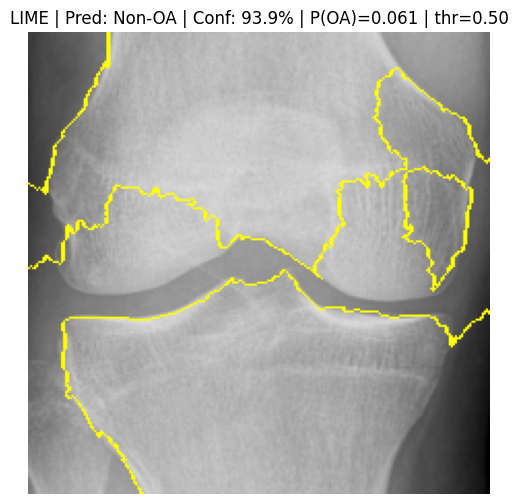

In [36]:
THRESHOLD = 0.50
NUM_SAMPLES = 1000
NUM_FEATURES = 8
HIDE_REST = False
POSITIVE_ONLY = True

uploaded = files.upload()
img_path = list(uploaded.keys())[0]
print("Uploaded:", img_path)

img_pil = image.load_img(img_path, target_size=(224, 224))
img_arr_01 = image.img_to_array(img_pil) / 255.0
img_batch = np.expand_dims(img_arr_01, axis=0).astype(np.float32)


prob_oa = float(model_resnet50.predict(img_batch, verbose=0)[0][0])
prob_non = 1.0 - prob_oa

pred_label = "OA" if prob_oa >= THRESHOLD else "Non-OA"
conf = prob_oa if pred_label == "OA" else prob_non

print(f"Prediction      : {pred_label}")
print(f"Confidence      : {conf*100:.2f}% ({pred_label})")
print(f"P(OA)           : {prob_oa:.4f}")
print(f"P(Non-OA)       : {prob_non:.4f}")
print(f"Threshold       : {THRESHOLD:.2f}")

img_uint8 = (img_arr_01 * 255).astype(np.uint8)


def lime_predict_fn(images_uint8):
    images_01 = images_uint8.astype(np.float32) / 255.0
    p_oa = model_resnet50.predict(images_01, verbose=0).reshape(-1)
    p_non = 1.0 - p_oa
    return np.stack([p_non, p_oa], axis=1)


explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(
    img_uint8,
    classifier_fn=lime_predict_fn,
    top_labels=2,
    num_samples=NUM_SAMPLES
)


label_to_explain = 1 if pred_label == "OA" else 0

temp, mask = explanation.get_image_and_mask(
    label=label_to_explain,
    positive_only=POSITIVE_ONLY,
    num_features=NUM_FEATURES,
    hide_rest=HIDE_REST
)


title = f"LIME | Pred: {pred_label} | Conf: {conf*100:.1f}% | P(OA)={prob_oa:.3f} | thr={THRESHOLD:.2f}"

plt.figure(figsize=(6,6))
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.axis("off")
plt.title(title)
plt.show()